<div style="background-image:url(images/bertinoro.jpg); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#333">First TIDES Training School</h1>
<h5 style="color:#FFF">Bertinoro (FC), Italy, June 1-5 2015</h5>

<h3 style="color:#EEE">Day 1: Data Acquisition and Processing with ObsPy</h3>

<h2 style="color:#FFF">Process Earthquake Data</h2>
</div>

In this notebook we will use raw data from the datacenters and process it so it is suitable for further processing.

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


The pre-downloaded data can be found in `~/Desktop/data/earthquake_data`

In [2]:
ls -lrt ~/Desktop/data/earthquake_data/waveforms

total 28
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 GCMT_2014_04_01__Mw_8_1/
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 GCMT_2014_04_04__Mw_6_2/
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 GCMT_2015_04_25__Mw_7_9/
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 GCMT_2015_05_12__Mw_7_2/
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 INGV_2012_05_29__Mw_5_6/
drwxr-xr-x 2 tides tides 4096 Mai 26 14:51 INGV_2015_01_23__Mw_4_3/
drwxr-xr-x 2 tides tides 4096 Mai 26 16:03 GCMT_2011_12_07__Mw_6_1/


In [3]:
ls -lrt ~/Desktop/data/earthquake_data/stations

total 2060
-rw-r--r-- 1 tides tides   62265 Mai 14 01:31 IV_PESA.xml
-rw-r--r-- 1 tides tides   43348 Mai 14 01:31 IV_CAVE.xml
-rw-r--r-- 1 tides tides  106116 Mai 14 01:31 IV_BOB.xml
-rw-r--r-- 1 tides tides  106128 Mai 14 01:31 IV_BDI.xml
-rw-r--r-- 1 tides tides   13771 Mai 14 01:31 SI_LUSI.xml
-rw-r--r-- 1 tides tides  196373 Mai 14 01:31 MN_VLC.xml
-rw-r--r-- 1 tides tides   64202 Mai 14 01:31 IV_TEOL.xml
-rw-r--r-- 1 tides tides  108069 Mai 14 01:31 IV_SALO.xml
-rw-r--r-- 1 tides tides   43363 Mai 14 01:31 IV_PRMA.xml
-rw-r--r-- 1 tides tides 1345846 Mai 14 01:31 all_stations.xml
-rw-r--r-- 1 tides tides     351 Mai 14 01:31 STATIONS


### Exercise: Process Data

1. Read the raw waveform data for event `GCMT_2015_04_25__Mw_7_9` station for station.
2. Read the corresponing station information.
3. Remove the instrument response. Use the `pre_filt` for filtering the data and filter it between 1 and 200 seconds.
4. Decimate to 10 Hz.
5. Save it all in "processed_data_1_200_seconds"

In [4]:
import os

data_folder = "/home/tides/Desktop/data/earthquake_data/waveforms/GCMT_2015_04_25__Mw_7_9"
output_folder = "processed_data_1_200_seconds"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

!ls $data_folder

IV_BDI_E.sac  IV_CAVE_E.sac  IV_PRMA_E.sac  IV_TEOL_E.sac  SI_LUSI_E.sac
IV_BDI.mseed  IV_CAVE.mseed  IV_PRMA.mseed  IV_TEOL.mseed  SI_LUSI.mseed
IV_BDI_N.sac  IV_CAVE_N.sac  IV_PRMA_N.sac  IV_TEOL_N.sac  SI_LUSI_N.sac
IV_BDI_Z.sac  IV_CAVE_Z.sac  IV_PRMA_Z.sac  IV_TEOL_Z.sac  SI_LUSI_Z.sac
IV_BOB_E.sac  IV_PESA_E.sac  IV_SALO_E.sac  MN_VLC_E.sac
IV_BOB.mseed  IV_PESA.mseed  IV_SALO.mseed  MN_VLC.mseed
IV_BOB_N.sac  IV_PESA_N.sac  IV_SALO_N.sac  MN_VLC_N.sac
IV_BOB_Z.sac  IV_PESA_Z.sac  IV_SALO_Z.sac  MN_VLC_Z.sac


In [5]:
import obspy

inv = obspy.read_inventory("/home/tides/Desktop/data/earthquake_data/stations/all_stations.xml")

In [6]:
import glob
import os

for filename in glob.glob(data_folder + "/*.mseed"):
    print("Processing file %s" % filename)
    st = obspy.read(filename)
    
    # Filter by applying a cosine taper during the instrument
    # deconvolution. Very simple and does not require to set
    # a water level.
    f2 = 1.0 / 200.0
    f3 = 1.0 / 1.0
    f1 = 0.8 * f2
    f4 = 1.2 * f3
    pre_filt = (f1, f2, f3, f4)
    st.attach_response(inv)
    st.remove_response(output="VEL", pre_filt=pre_filt, zero_mean=True,
                       taper=True)
    
    # We applied a pretty sharp filter in the frequency domain so 
    # we can savely resample without an additional aliasing filter.
    s_r = st[0].stats.sampling_rate
    desired_sr = 10.0
    factor = int(round(s_r / desired_sr))
    if factor > 1:
        st.decimate(factor=factor, no_filter=True)

    print(st)
    st.write(os.path.join(output_folder, os.path.basename(filename)), format="mseed")

Processing file /home/tides/Desktop/data/earthquake_data/waveforms/GCMT_2015_04_25__Mw_7_9/IV_CAVE.mseed
3 Trace(s) in Stream:
IV.CAVE..HHE | 2015-04-25T06:07:45.190000Z - 2015-04-25T07:42:00.290000Z | 10.0 Hz, 56552 samples
IV.CAVE..HHN | 2015-04-25T06:07:45.610000Z - 2015-04-25T07:42:01.110000Z | 10.0 Hz, 56556 samples
IV.CAVE..HHZ | 2015-04-25T06:07:47.750000Z - 2015-04-25T07:42:00.750000Z | 10.0 Hz, 56531 samples
Processing file /home/tides/Desktop/data/earthquake_data/waveforms/GCMT_2015_04_25__Mw_7_9/IV_PESA.mseed
3 Trace(s) in Stream:
IV.PESA..BHE | 2015-04-25T06:07:40.795000Z - 2015-04-25T07:42:03.395000Z | 10.0 Hz, 56627 samples
IV.PESA..BHN | 2015-04-25T06:07:46.845200Z - 2015-04-25T07:41:59.745200Z | 10.0 Hz, 56530 samples
IV.PESA..BHZ | 2015-04-25T06:07:43.145200Z - 2015-04-25T07:42:03.045200Z | 10.0 Hz, 56600 samples
Processing file /home/tides/Desktop/data/earthquake_data/waveforms/GCMT_2015_04_25__Mw_7_9/IV_PRMA.mseed
3 Trace(s) in Stream:
IV.PRMA..HHE | 2015-04-25T06:07

/home/tides/.anaconda/lib/python3.4/site-packages/obspy-0.10.2-py3.4-linux-x86_64.egg/obspy/mseed/core.py:729: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


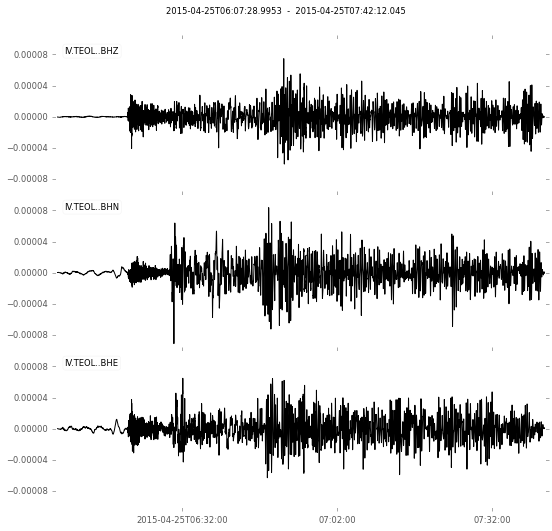

In [7]:
obspy.read("./processed_data_1_200_seconds/IV_TEOL.mseed").plot()